In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# autoreload modules
%load_ext autoreload
%autoreload 2

## Generate problem data

In [19]:
# Parameters
n = 10
m = 20
np.random.seed(0)

# Generate random holding and shortage costs
c_h = np.random.uniform(0.1, 0.5, n)
c_s = np.random.uniform(0.1, 0.5, n)

# Generate demand scenarios using Gaussian mixture model
mu_1 = np.random.uniform(0.5, 1.5, n)
mu_2 = np.random.uniform(0.5, 1.5, n)
sigma_1 = 0.1
sigma_2 = 0.1

d = np.vstack([np.random.normal(mu_1, sigma_1, n) if np.random.rand() < 0.5 else np.random.normal(mu_2, sigma_2, n) for _ in range(m)])
d = np.maximum(d, 0)

# CVaR parameters
beta = 0.95
kappa = 0.11
k = int((1-beta) * m)
alpha = kappa * k

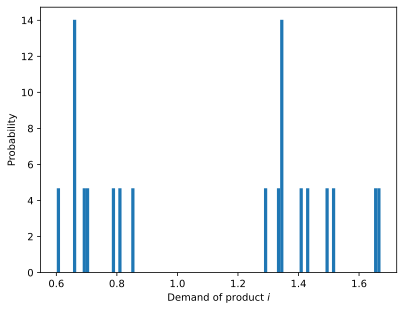

In [20]:
plt.hist(d[:,0], bins=100, alpha=1, density=True)
plt.xlabel(r"Demand of product $i$")
plt.ylabel(r"Probability")
plt.show()

## Form problem and solve via CVXPY

In [21]:
# Variables
x = cp.Variable(n, nonneg=True)
h = cp.Variable((m, n), nonneg=True)
s = cp.Variable((m, n), nonneg=True)

# Define vector of shortfall rates
z = cp.sum(s, axis=1) / cp.sum(d, axis=1)

# Constraints
# constraints = [h[i, :] >= x - d[i] for i in range(m)]
# constraints += [s[i, :] >= d[i] - x for i in range(m)]
# constraints += [cp.sum_largest(z, k) <= alpha]

# Vectorized constraints
constraints = [h >= x.reshape((-1,n))-d]
constraints += [s >= d-x.reshape((-1,n))]
constraints += [cp.sum_largest(z, k) <= alpha]


# Problem
objective = cp.Minimize(cp.sum(h @ c_h + s @ c_s) / m)
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND)

# Compilation took 2.378e-01 seconds vectorized.
# Compilation took 7.007e+00 seconds

# with m=10k
# Compilation took 2.002e+00 seconds vectorized.
# Compilation took 3.885e+02 seconds.


                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) May 25 11:09:03 AM: Your problem has 410 variables, 401 constraints, and 0 parameters.
(CVXPY) May 25 11:09:03 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 25 11:09:03 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 25 11:09:03 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 25 11:09:03 AM: Your problem is compiled with the SCIPY canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 25 11:09:03 AM: Compiling problem (target solver=MOSEK)

0.4590206389961116

In [22]:
print("Solve time: ", prob._solve_time)
print("CVaR at 0.95 level: ", np.
      mean(np.sort(z.value)[-k:]))

Solve time:  0.03226876258850098
CVaR at 0.95 level:  0.11000000000315696


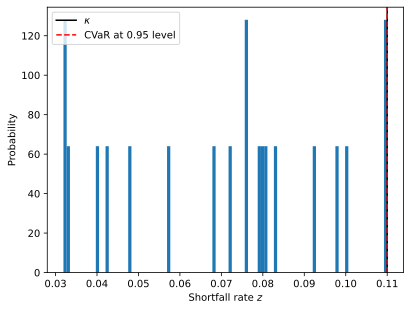

In [23]:
plt.hist(z.value, bins=100, alpha=1, density=True)
plt.axvline(kappa, color='black', linestyle='-', label=r"$\kappa$")
plt.axvline(np.mean(np.sort(z.value)[-k:]), color='red', linestyle='--', label=r"CVaR at 0.95 level")
plt.xlabel(r"Shortfall rate $z$")
plt.ylabel(r"Probability")
plt.legend()
plt.show()

## Form CVQP and solve via ADMM

In [24]:
# import scipy sparse block diagonal matrix
from scipy.sparse import block_diag

# form a block diagonal matrix with the 1xn matrix v repeated on the diagonal m
# times
v = np.ones((1, n))
A = block_diag([v * 1/d[i].sum() for i in range(m)])

print(A.shape)

# form the block matrix [Z,A] where Z is a sparse matrix of zeros of dimension m
# x (n+nm). use sparse matrices to save memory
from scipy.sparse import csr_matrix, hstack
Z = csr_matrix((m, n+n*m))
A = hstack([Z, A])

print(A.shape, type(A))


(20, 200)
(20, 410) <class 'scipy.sparse._coo.coo_matrix'>


In [25]:
from scipy.sparse import bmat, eye

I_n = eye(n, format='csr')
I_nm = eye(n*m, format='csr')

mI_n = bmat([[I_n]]*m)

blocks = [
    [-mI_n, I_nm, csr_matrix((n*m,n*m))],
    [mI_n, csr_matrix((n*m,n*m)), -I_nm],
    [csr_matrix((n*m,n)), I_nm, csr_matrix((n*m,n*m))],
    [csr_matrix((n*m,n)), csr_matrix((n*m,n*m)), I_nm],
    [I_n, csr_matrix((n,n*m)), csr_matrix((n,n*m))]
]

B = bmat(blocks)
B.shape, 4*n*m+n,n+2*n*m


((810, 410), 810, 410)

In [26]:
l = np.vstack(
    [
        -d.reshape((-1,1)),d.reshape((-1,1)),np.zeros((n*m,1)),np.zeros((n*m,1)),np.zeros((n,1))
    ]
).flatten()

def lower_clip(x):
    return np.maximum(x,l)



In [27]:
proj_As = [B]
proj_fns = [lower_clip]

nn = n+2*n*m
P = csr_matrix((nn,nn))
# repeat c_h m times
CH = np.tile(c_h, m)
CS = np.tile(c_s, m)



q = np.concatenate(
    [
        np.zeros(n), CH, CS
    ]
) / m

q.shape

(410,)

In [28]:
AtA = A.T @ A
BtB = B.T @ B

M = P + 1 * AtA + 1 * BtB

alpha = M[:n,:n]
z = M[n:,:n]
D = M[n:,n:]

from matplotlib import pyplot as plt
# plt.spy(M, markersize=0.1)

In [29]:
from scipy.sparse import diags
def custom_factor(A,B, rho=1.0, scale=1.0):
    AtA = A.T @ A
    BtB = B.T @ B
    
    M = P + rho * AtA + rho * BtB
    
    alpha = M[:n,:n]
    z = M[n:,:n]
    D = M[n:,n:]

    # D_inv = np.zeros(D.shape)
    # dinv_blocks_ = []
    # for i in range(2*m):
    #     s = i*n
    #     e = (i+1)*n
    #     dinv_ = np.linalg.inv(D[s:e,s:e].toarray())
    #     # D_inv[s:e,s:e] = dinv
    #     dinv_blocks_.append(dinv_)
    # D_inv_ = block_diag(dinv_blocks_)
    # assert np.allclose((D_inv_@D).toarray(), np.eye(2*m*n))

    # first block from 0 to (n+n*m)
    e = n*m
    di = D[:e,:e].diagonal()
    # sparse diagonal matrix with diagonal 1 / di
    D_inv_1 = diags(1 / di)
    dinv_blocks_2 = []
    for i in range(m):
        # rs = rho #/ scale
        r = ((1/d[i].sum())**2) * rho / scale**2
        s = i*n
        e = (i+1)*n
        # D_i = 2 * I + r**2 * 11^T
        D_i_inv = (1/(2*rho)) * np.eye(n) - (1 / (1+ r*1/(2*rho) * n)) * r/(4*rho**2)
        dinv_blocks_2.append(D_i_inv)

    R = 1/d.sum(axis=1)**2     

    dinv_blocks_ = [D_inv_1] + dinv_blocks_2
    D_inv = block_diag(dinv_blocks_)
    assert np.allclose((D_inv@D).toarray(), np.eye(2*m*n))
    np.set_printoptions(precision=2, linewidth=100)

    # sparse block diagonal matrix
    T1 = block_diag([csr_matrix((n,n)), D_inv])
    rho_neg = -alpha + z.T @ D_inv @ z
    rho_inv = np.array(np.linalg.inv(-rho_neg.toarray()))

    # sparse matrix from blocks, not diagonal
    u = bmat(
        [
            [-eye(n)],
            [D_inv @ z],
        ]
    )

    ut = u.T.tocsr()

    T2 = u @ rho_inv @ u.T

    # M_inv = T1.toarray() + T2

    def sparse_solve(y):
        t1 = T1 @ y
        
        t2 = (ut @ y)
        t2 = rho_inv @ t2
        t2 = u @ t2

        return t1 + t2
    
    return M, sparse_solve


In [30]:
scale = 1.0
M, sparse_solve = custom_factor(1/scale * A,B,rho=2.0,scale=scale)

In [31]:
# using the standard basis vectors, confirm that sparse_solve applies to the
# columns of M resulting in the identity matrix
from tqdm import tqdm

for i in tqdm(range(M.shape[0])):
    e = np.zeros(M.shape[0])
    e[i] = 1
    assert np.allclose(sparse_solve(M.toarray()[:,i]), e)

100%|██████████| 410/410 [00:00<00:00, 8663.12it/s]


In [17]:
# time soling by generating random vectors v and then solving via either
# sparse_solve or multiplying by the inverse
import time
trials = 10
sparse_times = []
dense_times = []
nn = M.shape[0]
for t in range(trials):
    v = np.random.rand(nn)
    start = time.time()
    x = sparse_solve(v)
    end = time.time()
    sparse_times.append(end-start)

    start = time.time()
    x2 = np.linalg.solve(M.toarray(), v)
    end = time.time()
    dense_times.append(end-start)

    assert np.allclose(x, x2)

print("Sparse solve time: ", np.mean(sparse_times))
print("Dense solve time: ", np.mean(dense_times))

Sparse solve time:  5.362033843994141e-05
Dense solve time:  5.359649658203125e-05


In [32]:
# alternative cvxpy formulation
w = cp.Variable(P.shape[0])
objective = cp.Minimize(q @ w)
constraints = [
    cp.sum_largest(A @ w, k) <= alpha,
    B@w >= l
]

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, canon_backend=cp.SCIPY_CANON_BACKEND,verbose=True)

                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) May 25 11:09:22 AM: Your problem has 410 variables, 910 constraints, and 0 parameters.
(CVXPY) May 25 11:09:22 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 25 11:09:22 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 25 11:09:22 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 25 11:09:22 AM: Your problem is compiled with the SCIPY canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 25 11:09:22 AM: Compiling problem (target solver=MOSEK)

0.9931835004095801

In [33]:
from admm import run_admm

x, history = run_admm(    
    # P, q, A, beta, kappa, proj_As, proj_fns, 
    P, q, A, beta, kappa, proj_As, proj_fns, 
    max_iter=1000, 
    alpha_over=1.7, rho=1, 
    #  warm=x_cvxpy_.value, 
    verbose = True,
    custom_factor = custom_factor,
    print_freq=100
)

print("Objval: ", history["objval"][-1])
print(f"Relative error: {np.abs(history['objval'][-1] - prob.value) / prob.value}")
print(np.sort(A @ x)[::-1][:k].sum() / m, kappa)

iter: 0, objval: -0.5961064173312147, r_norm: 16.483072897831544, s_norm: 77.24491018515424, u_norm: 17.145377332071682, time: 0.14919495582580566
iter: 100, objval: 0.9720999559246116, r_norm: 0.03915202029635571, s_norm: 0.15668071557079472, u_norm: 13.62796745659761, time: 0.2475590705871582
iter: 200, objval: 0.9896771958701365, r_norm: 0.020684724691570566, s_norm: 0.06860967496235924, u_norm: 14.189881731615944, time: 0.2888660430908203
iter: 300, objval: 0.9895098799151005, r_norm: 0.012143226162482125, s_norm: 0.048047653254997075, u_norm: 14.699452325788878, time: 0.3199760913848877
iter: 400, objval: 0.9902269028647723, r_norm: 0.006932644553463208, s_norm: 0.02145723971666154, u_norm: 14.871496083391524, time: 0.34975099563598633
iter: 500, objval: 0.9900092115180948, r_norm: 0.004464058297739987, s_norm: 0.01608198764595041, u_norm: 15.049129780210496, time: 0.38071227073669434
iter: 600, objval: 0.9908417323424004, r_norm: 0.003732814339533766, s_norm: 0.006796105640810577